In [3]:
import pypsa
import yaml
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import seaborn as sns
from shapely.geometry import Point


import sys
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Patch
from matplotlib.legend_handler import HandlerPatch


import cartopy.crs as ccrs
import cartopy
from cartopy.io import shapereader
import cartopy.feature as cfeature


import multiprocessing as mp
from itertools import product

from pypsa.plot import projected_area_factor
from pypsa.descriptors import get_switchable_as_dense as as_dense

PATH = "https://github.com/fneum/spatial-sector/tree/dbfda1f7f12be0176335d665f9b4814a57105b3e/workflows"
SCRIPTS_PATH = "https://github.com/PyPSA/pypsa-eur/tree/008539d635c1da9fff3d4852bd0ac0444e9cd52c/scripts/"

sys.path.append(SCRIPTS_PATH)

plt.style.use(["bmh"])

xr.set_options(display_style="html")

%matplotlib inline

In [4]:
n3=pypsa.Network(r"./elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
bus_name = n3.buses.index[515]
bus_name

"Index(['AL1 0 H2', 'AT1 0 H2', 'AT1 1 H2', 'AT1 2 H2', 'AT1 3 H2', 'BA1 0 H2',\n       'BE1 0 H2', 'BE1 1 H2', 'BE1 2 H2', 'BE1 3 H2',\n       ...\n       'SE2 0 H2', 'SE2 1 H2', 'SE2 2 H2', 'SE2 3 H2', 'SE2 4 H2', 'SE2 5 H2',\n       'SE2 6 H2', 'SE2 7 H2', 'SI1 0 H2', 'SK1 0 H2'],\n      dtype='object', name='name', length=256)"

In [6]:
n3.mremove("Bus", [bus_name])

In [7]:
def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label

In [8]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1: continue
            names = ifind.index[ifind == i]
            c.df.loc[names, 'location'] = names.str[:i]

In [10]:
with open(r"/./config.yaml") as file:
    config = yaml.safe_load(file)

In [11]:
tech_colors = config["plotting"]["tech_colors"]
tech_colors["load"] = "red"

In [12]:
class HandlerCircle(HandlerPatch):
    """
    Legend Handler used to create circles for legend entries.

    This handler resizes the circles in order to match the same dimensional
    scaling as in the applied axis.
    """

    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        fig = legend.get_figure()
        ax = legend.axes

        unit = np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0][1]
        radius = orig_handle.get_radius() * unit * (72 / fig.dpi)
        center = 5 - xdescent, 3 - ydescent
        p = plt.Circle(center, radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def add_legend_circles(
    ax, sizes, labels, scale=1, srid=None, patch_kw={}, legend_kw={}
):
    if srid is not None:
        area_correction = projected_area_factor(ax, n.srid) ** 2
        sizes = [s * area_correction for s in sizes]

    handles = make_legend_circles_for(sizes, scale, **patch_kw)

    legend = ax.legend(
        handles, labels, handler_map={Circle: HandlerCircle()}, **legend_kw
    )

    ax.add_artist(legend)


def add_legend_lines(ax, sizes, labels, scale=1, patch_kw={}, legend_kw={}):
    handles = [Line2D([0], [0], linewidth=s / scale, **patch_kw) for s in sizes]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)


def add_legend_patch(ax, colors, labels, patch_kw={}, legend_kw={}):
    handles = [Patch(facecolor=c, **patch_kw) for c in colors]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]

In [13]:
n3.generators.eval("capital_cost * p_nom_opt").div(1e9).groupby(
    n3.generators.carrier
).sum()

carrier
gas                                            0.000000
offwind-ac                                     2.930067
offwind-dc                                    13.065366
oil                                            0.000000
onwind                                       108.779313
residential rural solar thermal                0.000005
residential urban decentral solar thermal      0.000006
ror                                           14.782789
services rural solar thermal                   0.000005
services urban decentral solar thermal         0.000006
solar                                         54.519953
solar rooftop                                 20.690562
urban central solar thermal                    0.168461
dtype: float64

In [14]:
available = n3.snapshot_weightings.generators @ (
    n3.generators_t.p_max_pu * n3.generators.p_nom_opt
)
available

Generator
AL1 0 offwind-ac                                             2.735107e-01
AL1 0 onwind                                                 3.900702e-02
AL1 0 residential rural solar thermal collector              8.775862e-01
AL1 0 residential urban decentral solar thermal collector    1.148415e+00
AL1 0 ror                                                    1.772497e+05
                                                                 ...     
SK1 0 services rural solar thermal collector                 2.742808e-01
SK1 0 services urban decentral solar thermal collector       3.132959e-01
SK1 0 solar                                                  2.395137e+07
SK1 0 solar rooftop                                          5.811971e+06
SK1 0 urban central solar thermal collector                  7.403318e-01
Name: generators, Length: 2375, dtype: float64

In [15]:
used = n3.snapshot_weightings.generators @ n3.generators_t.p
used

Generator
AL1 0 offwind-ac       2.073567e-01
AL1 0 onwind           2.220532e-02
AL1 0 ror              1.768265e+05
AL1 0 solar            1.264808e+07
AT1 0 onwind           1.999203e+07
                           ...     
SE2 5 solar rooftop    1.941773e+06
SE2 6 solar rooftop    3.838043e+00
SE2 7 solar rooftop    1.239794e+05
SI1 0 solar rooftop    2.462193e+06
SK1 0 solar rooftop    5.811830e+06
Name: generators, Length: 2375, dtype: float64

In [16]:
available = (
    available.groupby(n3.generators.carrier)
    .sum()
    .drop(set(n3.generators.carrier.values).intersection(["gas", "oil"]))
    .div(1e6)
)  # TWh
available

carrier
offwind-ac                                     53.671515
offwind-dc                                    258.252320
onwind                                       2534.257224
residential rural solar thermal                 0.000093
residential urban decentral solar thermal       0.000121
ror                                           169.155430
services rural solar thermal                    0.000088
services urban decentral solar thermal          0.000106
solar                                        1393.952997
solar rooftop                                 552.485796
urban central solar thermal                     6.943166
Name: generators, dtype: float64

In [17]:
used = (
    used.groupby(n3.generators.carrier)
    .sum()
    .drop(set(n3.generators.carrier.values).intersection(["gas", "oil"]))
    .div(1e6)
)  # TWh
used

carrier
offwind-ac                                     47.946192
offwind-dc                                    239.431557
onwind                                       2321.319909
residential rural solar thermal                 0.000056
residential urban decentral solar thermal       0.000078
ror                                           168.759277
services rural solar thermal                    0.000054
services urban decentral solar thermal          0.000067
solar                                        1316.901591
solar rooftop                                 551.899934
urban central solar thermal                     6.941329
Name: generators, dtype: float64

In [18]:
curtailed = available - used
curtailed.sum()

315.5188120688672

In [22]:
# Function to shift the year of a datetime index
def shift_year_to_2030(datetime_index):
    return datetime_index.map(lambda dt: dt.replace(year=2030 if dt.year == 2013 else dt.year))

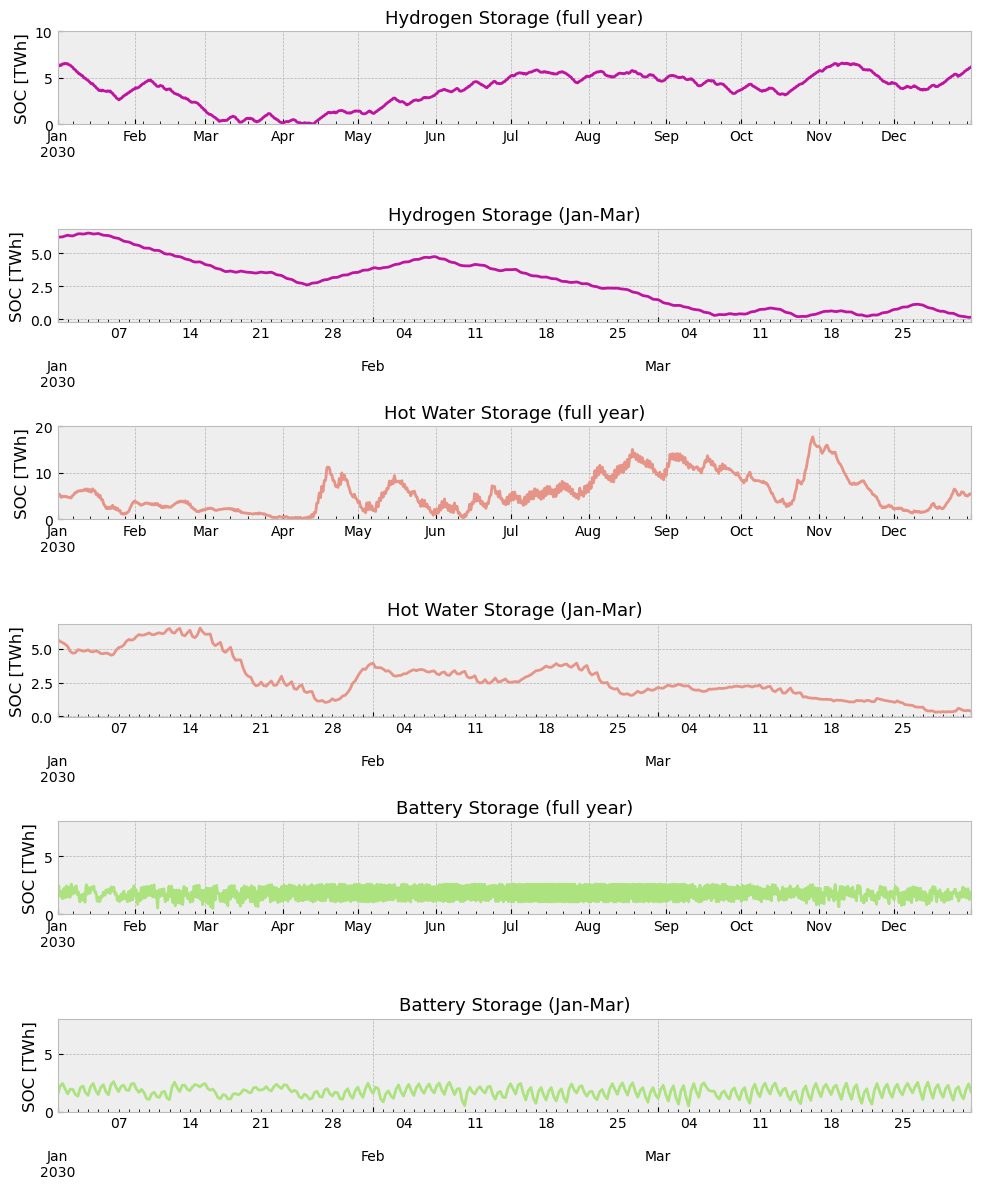

In [26]:
# Apply the year shift to all relevant dataframes
n3.stores_t.e.index = shift_year_to_2030(n3.stores_t.e.index)

fig, axs = plt.subplots(6, 1, figsize=(10, 12))

ax = axs[0]
n3.stores_t.e.filter(like="H2 Store", axis=1).sum(axis=1).div(1e6).plot(
    ax=ax,
    ylabel="SOC [TWh]",
    xlabel="",
    color=tech_colors["hydrogen storage"],
    ylim=(0, 10),
)
ax.set_title("Hydrogen Storage (full year)", fontsize=13)

ax = axs[2]
n3.stores_t.e.filter(like="water tank", axis=1).sum(axis=1).div(1e6).plot(
    ax=ax,
    ylabel="SOC [TWh]",
    xlabel="",
    color=tech_colors["hot water storage"],
    ylim=(0, 20),
)
ax.set_title("Hot Water Storage (full year)", fontsize=13)

ax = axs[1]
n3.stores_t.e.filter(like="H2 Store", axis=1).sum(axis=1).loc["2030-01":"2030-03"].div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["hydrogen storage"])
ax.set_title("Hydrogen Storage (Jan-Mar)", fontsize=13)

ax = axs[3]
n3.stores_t.e.filter(like="water tank", axis=1).sum(axis=1).loc["2030-01":"2030-03"].div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["hot water storage"])
ax.set_title("Hot Water Storage (Jan-Mar)", fontsize=13)

ax = axs[5]
n3.stores_t.e.filter(like="battery", axis=1).sum(axis=1).loc["2030-01":"2030-03"].div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["battery"], ylim=(0, 8))
ax.set_title("Battery Storage (Jan-Mar)", fontsize=13)

ax = axs[4]
n3.stores_t.e.filter(like="battery", axis=1).sum(axis=1).div(
    1e6
).plot(ax=ax, ylabel="SOC [TWh]", xlabel="", color=tech_colors["battery"], ylim=(0, 8))
ax.set_title("Battery Storage (full year)", fontsize=13)

plt.tight_layout()

#plt.savefig(f"{OUTPUT_SCENARIO}/soc.pdf", bbox_inches="tight")

In [31]:
unique_link_carriers = n3.links.carrier.unique()
GAS_NETWORK = "gas pipeline" in unique_link_carriers
H2_NETWORK = any("H2 pipeline" in ulc for ulc in unique_link_carriers)

In [34]:
n3.links.filter(like="biomass CHP CC", axis=0).filter(
    regex="(name|bus|efficiency|cost)"
).iloc[2]

bus0                               EU solid biomass
bus1                                          AT1 1
capital_cost                          219253.701431
efficiency                                    0.233
marginal_cost                              4.589574
bus2                       AT1 1 urban central heat
efficiency2                                  0.8718
bus3                                 co2 atmosphere
efficiency3                                  -0.333
bus4                                     co2 stored
efficiency4                                   0.333
marginal_cost_quadratic                         0.0
stand_by_cost                                   0.0
start_up_cost                                   0.0
shut_down_cost                                  0.0
Name: AT1 1 urban central solid biomass CHP CC, dtype: object

In [10]:
def nodal_balance(n, carrier, time=slice(None), aggregate=None, energy=True):
    if not isinstance(carrier, list):
        carrier = [carrier]

    one_port_data = {}

    for c in n.iterate_components(n.one_port_components):
        df = c.df[c.df.bus.map(n.buses.carrier).isin(carrier)]

        if df.empty:
            continue

        s = c.pnl.p.loc[time, df.index] * df.sign

        s = s.groupby([df.bus.map(n.buses.location), df.carrier], axis=1).sum()

        one_port_data[c.list_name] = s

    branch_data = {}

    for c in n.iterate_components(n.branch_components):
        for col in c.df.columns[c.df.columns.str.startswith("bus")]:
            end = col[3:]

            df = c.df[c.df[col].map(n.buses.carrier).isin(carrier)]

            if df.empty:
                continue

            s = -c.pnl[f"p{end}"].loc[time, df.index]

            s = s.groupby([df[col].map(n.buses.location), df.carrier], axis=1).sum()

            branch_data[(c.list_name, end)] = s

    branch_balance = pd.concat(branch_data).groupby(level=[0, 2]).sum()
    one_port_balance = pd.concat(one_port_data)

    def skip_tiny(df, threshold=1e-1):
        return df.where(df.abs() > threshold)

    branch_balance = skip_tiny(branch_balance)
    one_port_balance = skip_tiny(one_port_balance)

    balance = pd.concat([one_port_balance, branch_balance]).stack(level=[0, 1])

    balance.index.set_names(["component", "bus"], level=[0, 2], inplace=True)

    if energy:
        balance = balance * n.snapshot_weightings.generators

    if aggregate is not None:
        keep_levels = balance.index.names.difference(aggregate)
        balance = balance.groupby(level=keep_levels).sum()

    return balance

In [40]:
carrier = [
    "residential rural heat",
    "services rural heat",
    "residential urban decentral heat",
    "services urban decentral heat",
    "urban central heat",
]
df = (
    nodal_balance(n3, carrier, aggregate=["bus", "component"], energy=False)
    .unstack()
    .fillna(0.0)
    .div(1e3)
    .round(1)
)
df

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:32: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:32: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:32: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b8

carrier,agriculture heat,low-temperature heat for industry,residential rural gas boiler,residential rural ground heat pump,residential rural heat,residential rural resistive heater,residential rural water tanks charger,residential rural water tanks discharger,residential urban decentral air heat pump,residential urban decentral biomass boiler,...,services urban decentral water tanks discharger,urban central air heat pump,urban central gas CHP,urban central gas boiler,urban central heat,urban central resistive heater,urban central solar thermal,urban central solid biomass CHP,urban central water tanks charger,urban central water tanks discharger
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-21.6,-6.8,9.4,106.3,-105.8,0.3,-10.7,0.6,129.1,57.2,...,1.0,11.4,8.5,35.3,-109.8,82.4,0.0,11.5,-33.5,0.9
2013-01-01 06:00:00,-21.6,-6.8,20.6,108.0,-135.0,2.5,-0.6,4.4,129.7,62.6,...,0.8,11.5,6.3,44.1,-133.8,61.0,0.1,11.5,-6.3,12.5
2013-01-01 12:00:00,-21.6,-6.8,19.8,107.0,-129.9,1.7,-1.1,2.5,133.5,62.5,...,0.0,11.6,10.7,57.4,-124.4,31.9,0.6,11.5,-4.9,12.5
2013-01-01 18:00:00,-21.6,-6.8,10.7,106.5,-112.6,0.3,-5.3,0.4,126.9,61.3,...,0.3,11.0,13.7,44.3,-107.4,13.8,0.0,11.5,-0.9,20.7
2013-01-02 00:00:00,-21.6,-6.8,6.9,102.3,-104.5,0.0,-5.7,1.0,122.6,63.3,...,0.7,10.7,12.4,54.9,-111.6,5.4,0.0,11.5,-0.2,23.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-30 18:00:00,-21.6,-6.8,5.3,106.0,-108.9,1.0,-3.4,0.0,127.2,62.2,...,0.0,10.4,27.0,27.2,-106.3,68.2,0.0,11.5,-33.9,2.8
2013-12-31 00:00:00,-21.6,-6.8,6.3,104.8,-106.2,0.4,-5.7,0.4,125.9,62.0,...,0.4,10.4,24.2,32.9,-109.9,71.7,0.0,11.5,-36.3,2.3
2013-12-31 06:00:00,-21.6,-6.8,22.5,108.6,-135.8,1.8,-0.3,3.1,128.7,63.0,...,0.2,11.0,13.8,41.4,-133.7,65.1,0.6,11.5,-12.6,9.8


In [41]:
def cumulative_share(n, carrier, sortby="supply/demand", df=None):
    if df is None:
        to_drop = [
            "AC",
            "DC",
            "H2 pipeline",
            "gas pipeline",
            "gas pipeline new",
            "H2 pipeline retrofitted",
        ]

        balance = nodal_balance(n, carrier, aggregate=["snapshot"])

        balance = balance.groupby(["bus", "carrier"]).sum().unstack("carrier")
        balance.drop(balance.columns.intersection(to_drop), axis=1, inplace=True)

        supply = balance.where(balance > 0).sum(axis=1)
        demand = -balance.where(balance < 0).sum(axis=1)

        df = pd.concat({"supply": supply, "demand": demand}, axis=1)

    df = df.div(df.sum()) * 100

    df["sortby"] = df.eval(sortby)

    df.sort_values(by="sortby", inplace=True)

    df.drop("sortby", axis=1, inplace=True)

    lead = pd.DataFrame({"supply": [0], "demand": [0]})

    df = pd.concat([lead, df])

    return df.cumsum()

In [43]:
cumulative_share(n3, carrier="H2")

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:32: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:32: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_37425/799257463.py:45: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pan

,supply,demand
0,0.000000,0.000000
DE1 50,0.000000,0.041283
DE1 48,0.000000,0.054950
DE1 82,0.000000,0.090036
DE1 45,0.000000,0.198320
...,...,...
DE1 67,89.719225,99.886857
GB0 14,92.532522,99.943120
DE1 5,93.541753,99.956804
DE1 6,95.979670,99.988490


In [44]:
def plot_price_duration_curve(n, carrier, fn=None):
    df = n.buses_t.marginal_price.loc[:, n.buses.carrier == carrier]

    df = df.stack()

    to_plot = df.sort_values(ascending=False).reset_index(drop=True)

    to_plot.index = [i / len(df) * 100 for i in to_plot.index]

    fig, ax = plt.subplots(figsize=(4, 2.5))
    to_plot.plot(
        ax=ax,
    )
    plt.xlabel("share of snapshots and nodes [%]")
    plt.ylabel("nodal price [EUR/MWh]")
    plt.axvline(0, linewidth=0.5, linestyle=":", color="grey")
    plt.axvline(100, linewidth=0.5, linestyle=":", color="grey")
    plt.axhline(0, linewidth=0.5, linestyle=":", color="grey")

    if carrier == "H2":
        title = "Hydrogen"
        plt.ylim([-20, 350])
    elif carrier == "AC":
        title = "Electricity"
        plt.ylim([-100, 1000])
    else:
        title = carrier

    plt.title(title, fontsize=12, color="#343434")

    #if fn is not None:
    #    plt.savefig(fn, bbox_inches="tight")
    #    plt.close()

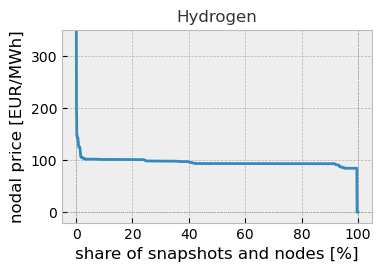

In [51]:
plot_price_duration_curve(n3, carrier="H2")

In [52]:
carriers = [
    "AC",
    "H2",
    "residential rural heat",
    "services rural heat",
    "residential urban decentral heat",
    "services urban decentral heat",
    "urban central heat",
    "low voltage",
]

if GAS_NETWORK:
    carriers.append("gas")

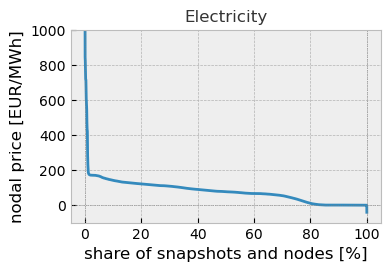

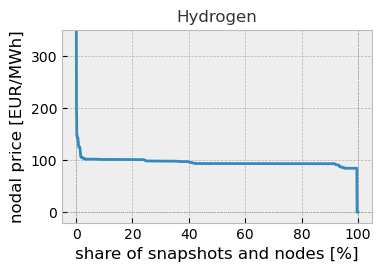

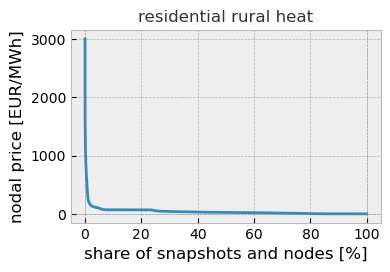

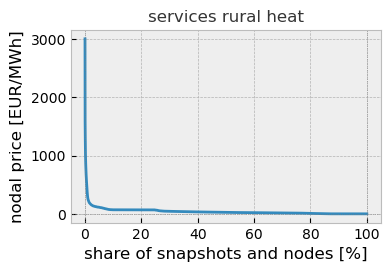

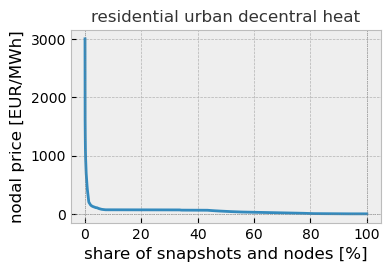

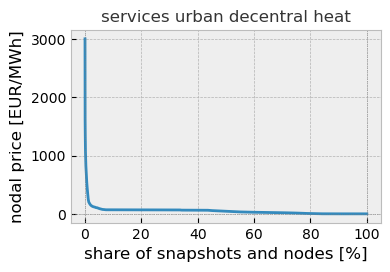

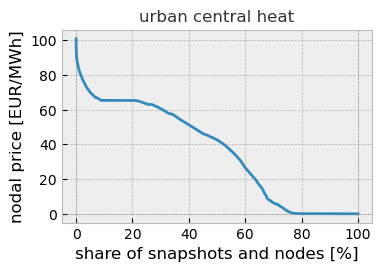

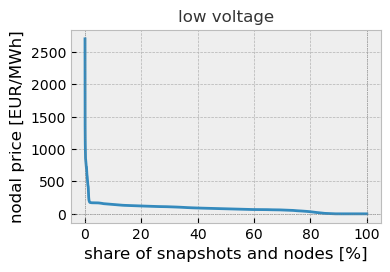

In [53]:
for carrier in carriers:
    plot_price_duration_curve(n3, carrier)

In [ ]:
carriers = {
        "offwind-ac": "Offshore Wind (AC)",
        "offwind-dc": "Offshore Wind (DC)",
        "onwind": "Onshore Wind",
        "ror": "Run of River",
        "solar": "Utility-scale Solar PV",
        "solar rooftop": "Rooftop Solar PV",
    }

In [21]:
def curtailment(n, carriers=None):
    avail = n.generators_t.p_max_pu * n.generators.p_nom_opt
    dispatch = n.generators_t.p

    curtail = n.snapshot_weightings.generators @ (avail - dispatch)

    curtail = (
        curtail.groupby([n.generators.bus.map(n.buses.location), n.generators.carrier])
        .sum()
        .unstack()
    )

    if carriers is not None:
        curtail = curtail[carriers]

    return curtail.drop("EU", axis=0).stack().div(1e6)

In [59]:
curtailment(n3).filter(like="ror").filter(like="DE").sum()

0.05930908351021005

In [60]:
n3.links_t.p0.filter(like="methanolisation").filter(like="DE").sum().sum()

185.16686463930645

In [71]:
n3.generators.eval("capital_cost * p_nom_opt").filter(like="DE").div(1e9).groupby(
    n3.generators.carrier
).sum()

carrier
offwind-ac                                    0.379552
offwind-dc                                    4.380764
onwind                                       13.969582
residential rural solar thermal               0.000002
residential urban decentral solar thermal     0.000002
ror                                           0.848572
services rural solar thermal                  0.000002
services urban decentral solar thermal        0.000002
solar                                         4.966535
solar rooftop                                 3.301162
urban central solar thermal                   0.000002
dtype: float64

In [46]:
def plot_pipeline_loading(network, min_capacity=20, fn=None):
    line_width_factor = 2e3

    n = network.copy()

    n.mremove("Bus", n.buses.index[n.buses.carrier != "AC"])
    n.mremove("Link", n.links.index[~n.links.carrier.str.contains("H2 pipeline")])

    n.mremove("Link", n.links.index[n.links.p_nom_opt < min_capacity])
    n.links.bus0 = n.links.bus0.str.replace(" H2", "")
    n.links.bus1 = n.links.bus1.str.replace(" H2", "")

    link_loading = n.links_t.p0.abs().mean() / n.links.p_nom_opt * 100

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs}, dpi=300)

    cmap = plt.cm.OrRd
    norm = mcolors.Normalize(vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    link_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(link_loading)))), index=link_loading.index
    )

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=0.005,
        bus_colors="k",
        link_colors=link_colors,
        link_widths=n.links.p_nom_opt / line_width_factor,
        branch_components=["Link"],
    )

    sizes = [1, 3]
    labels = [f"{s} GW" for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        scale=line_width_factor / 1e3,
        legend_kw=dict(title="Pipe Capacity", bbox_to_anchor=(1.03, 0.62)),
        patch_kw=dict(color="lightgrey"),
    )

    axins = ax.inset_axes([0.05, 0.8, 0.3, 0.2])
    curve = link_loading.sort_values().reset_index(drop=True)
    curve.index = [c / curve.size * 100 for c in curve.index]
    curve.plot(
        ax=axins,
        ylim=(-5, 105),
        yticks=[0, 25, 50, 75, 100],
        c="firebrick",
        linewidth=1.5,
    )
    axins.annotate("loading [%]", (3, 83), color="darkgrey", fontsize=9)
    axins.annotate("pipes [%]", (55, 7), color="darkgrey", fontsize=9)
    axins.grid(True)

    cbar = plt.colorbar(
        sm,
        orientation="vertical",
        shrink=0.7,
        ax=ax,
        label="Average Loading / Pipe Capacity [%]",
    )

    #if fn is not None:
    #    plt.savefig(fn, bbox_inches="tight")
    #    plt.close()

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


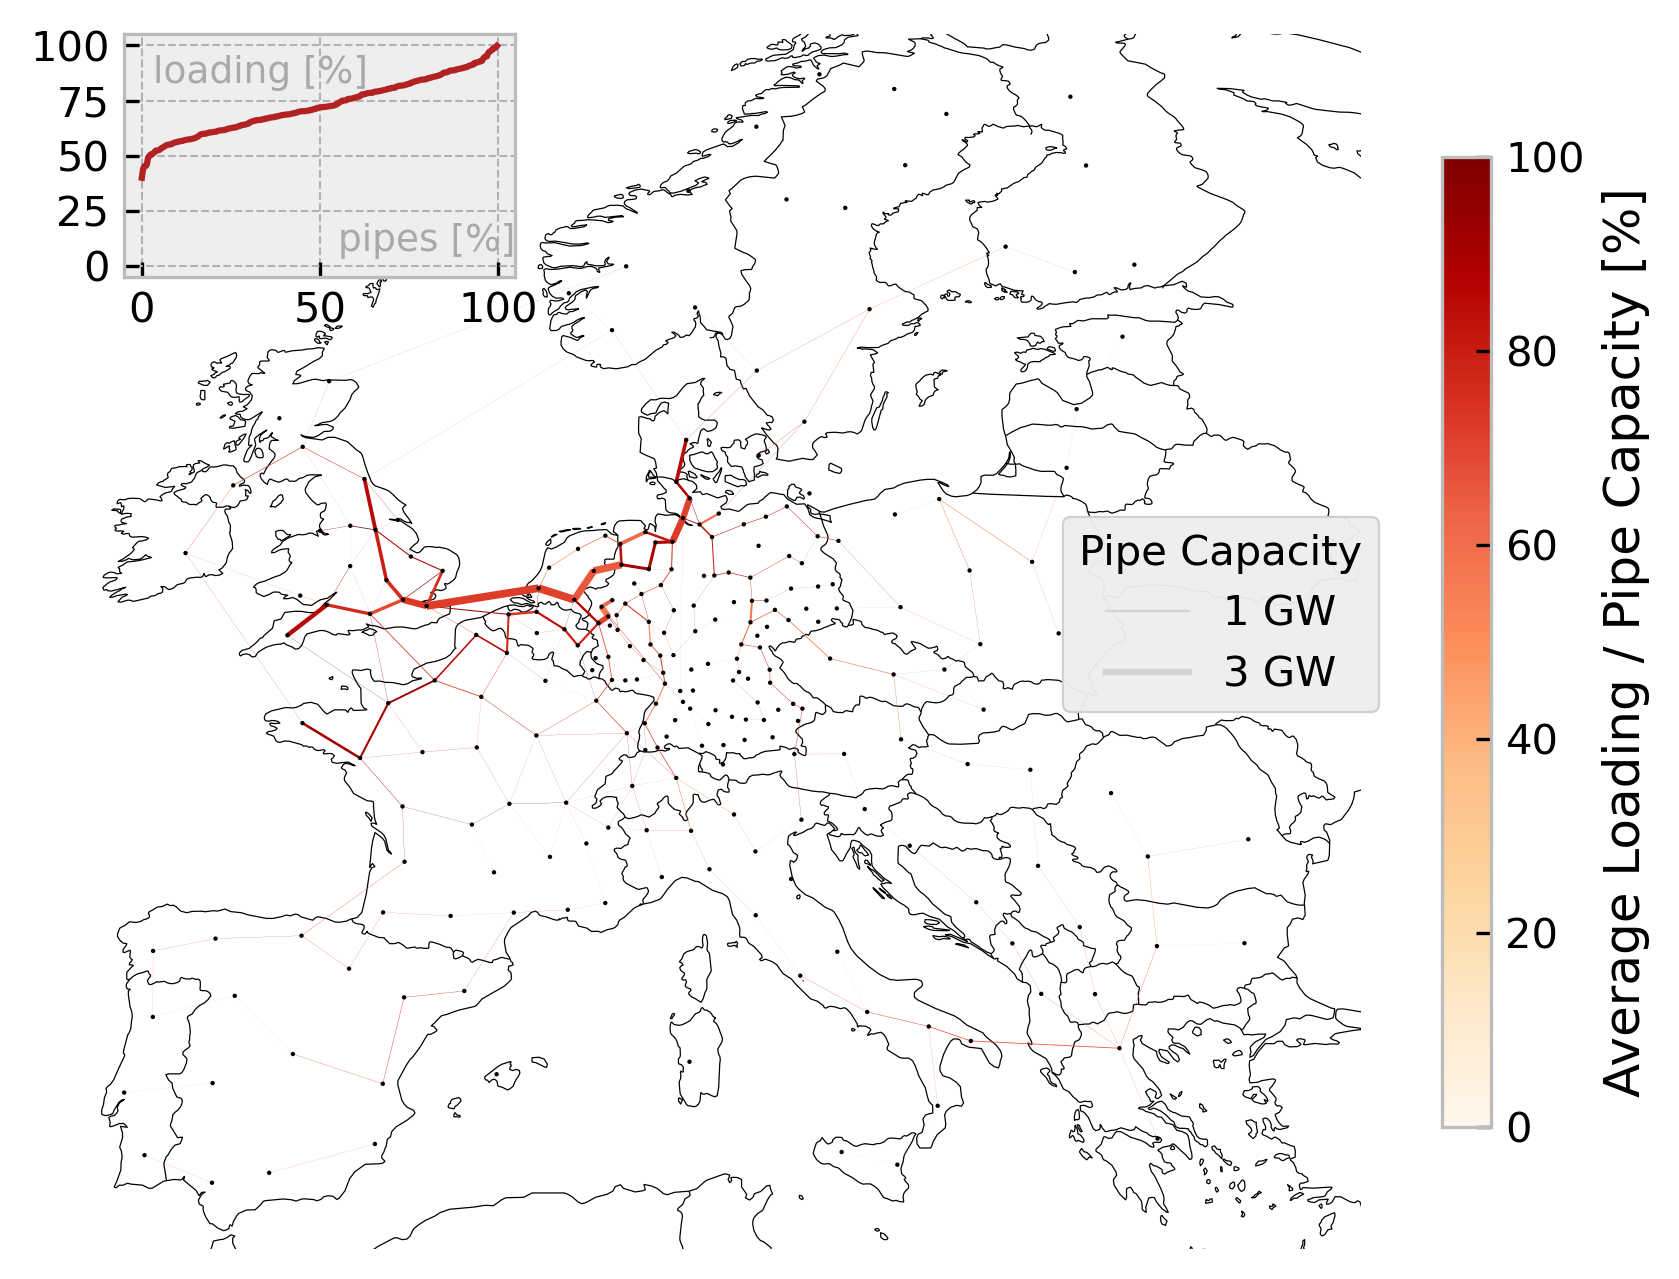

In [47]:
plot_pipeline_loading(n3)

In [44]:
n_s = n3.copy()

n_s.mremove("Bus", n_s.buses.index[n_s.buses.carrier != "AC"])
n_s.mremove("Link", n_s.links.index[~n_s.links.carrier.str.contains("H2 pipeline")])

n_s.mremove("Link", n_s.links.index[n_s.links.p_nom_opt < 0])
n_s.links.bus0 = n_s.links.bus0.str.replace(" H2", "")
n_s.links.bus1 = n_s.links.bus1.str.replace(" H2", "")
#link_loading1 = n_s.links_t.p0.abs().mean() / n_s.links.p_nom_opt * 100
#link_loading1 = n_s.links_t.p0.abs().mean() #/ n_s.links.p_nom_opt * 100
link_loading1 = n_s.links.p_nom_opt
link_loading1.sort_values(ascending=False).head(15)

Link
H2 pipeline NL1 1 -> NL1 2      3776.555471
H2 pipeline GB0 9 -> NL1 1      3708.938478
H2 pipeline DE1 29 -> NL1 4     3501.991298
H2 pipeline NL1 2 -> NL1 4      3433.027384
H2 pipeline DE1 28 -> DE1 77    3217.015603
H2 pipeline GB0 5 -> GB0 9      3110.000411
H2 pipeline DE1 28 -> DE1 6     2989.590841
H2 pipeline DE1 44 -> DE1 84    2940.535591
H2 pipeline DE1 84 -> DE1 91    2559.843257
H2 pipeline GB0 11 -> GB0 16    2098.546245
H2 pipeline DE1 24 -> DE1 44    1798.517525
H2 pipeline GB0 4 -> GB0 8      1797.875478
H2 pipeline DE1 5 -> DE1 56     1762.884301
H2 pipeline GB0 1 -> GB0 5      1727.728347
H2 pipeline DE1 72 -> DK1 0     1722.404469
Name: p_nom_opt, dtype: float64

In [45]:
link_loading1.describe()

count     474.000000
mean      218.981072
std       538.319636
min         0.004673
25%         6.844338
50%        34.889044
75%       141.292603
max      3776.555471
Name: p_nom_opt, dtype: float64

In [56]:
def calculate_twkm(n, selection=None, decimals=1, which="optimal"):
    if selection is None:
        selection = [
            "H2 pipeline",
            "H2 pipeline retrofitted",
            "gas pipeline",
            "gas pipeline new",
            "DC",
        ]

    twkm = n.links.loc[n.links.carrier.isin(selection)]

    if which == "optimal":
        link_request = "p_nom_opt"
        line_request = "s_nom_opt"
    elif which == "added":
        link_request = "(p_nom_opt - p_nom)"
        line_request = "(s_nom_opt - s_nom)"
    elif which == "existing":
        link_request = "p_nom"
        line_request = "s_nom"

    twkm = twkm.eval(f"length*{link_request}").groupby(twkm.carrier).sum() / 1e6  # TWkm
    twkm["AC"] = n.lines.eval(f"length*{line_request}").sum() / 1e6  # TWkm

    twkm.index.name = None

    return twkm.round(decimals)

In [57]:
calculate_twkm(n3, which="optimal")

DC              49.0
H2 pipeline     13.4
AC             355.3
dtype: float64

In [58]:
pd.DataFrame(
    {key: calculate_twkm(n3, which=key) for key in ["optimal", "added", "existing"]}
).stack()

DC           optimal      49.0
             added        40.5
             existing      8.6
H2 pipeline  optimal      13.4
             added        13.4
             existing      0.0
AC           optimal     355.3
             added        40.4
             existing    314.9
dtype: float64